In [44]:
import json
import sys
import os
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


def load_json(file_path):
    with open(f"{file_path}") as f:
        data = json.load(f)
    return data

def write_json(data, file_path):
    with open(f"{file_path}", "w") as f:
        json.dump(data, f, indent=4)

def load_csv(file_path):
    with open(file_path, "r") as f:
        # split by ;
        data = f.readlines()
        header = data[0].split(";")
        data = [line.split(";") for line in data[1:]]
        data = [dict(zip(header, line)) for line in data]
    return data


def approach_to_regular_name(approach: str):
    approach = approach.upper()
    match approach:
        case "HTML":
            return "HTML"
        case "CSV":
            return "CSV"
        case "JSON-RECORDS":
            return "JSON-Records"
        case "MARKDOWN":
            return "Markdown"
        case _:
            raise ValueError(f"Unknown approach: {approach}")
        
def tabtree_approach_to_regular_name(approach: str):
    if approach.startswith("tabtree-"):
        approach = approach[8:]
    
    match approach:
        case "base":
            return "Base"
        case "text":
            return "Text"
        case "text-augmented-with-context-intersection":
            return "Text Augm. w/ Context-I."
        case _:
            raise ValueError(f"Unknown approach: {approach}")
        
def all_approaches_by_list(approach_str_list: List[str]):
    if len(approach_str_list) == 1:
        try:
            return approach_to_regular_name(approach_str_list[0])
        except ValueError:
            try:
                return tabtree_approach_to_regular_name(approach_str_list[0])
            except ValueError:
                raise ValueError(f"Unknown approach: {approach_str_list[0]}") 
    else:
        try:
            return tabtree_approach_to_regular_name("-".join(approach_str_list))
        except ValueError:
            raise ValueError(f"Unknown approach: {approach_str_list}")

In [45]:
baselines_file = load_json("../data/evaluation/qa/evaluation_results-2025-04-01-21-32-33.json")
baselines = baselines_file["evaluation_results"]
baselines_error_count = load_json("../data/evaluation/qa/evaluation_results-2025-04-02-18-49-40.json")["evaluation_results"]

tabtree_base_file = load_json("../data/evaluation/qa/evaluation_results-2025-04-01-17-30-32.json")
tabtree_base = tabtree_base_file["evaluation_results"]
tabtree_base_error_count = load_json("../data/evaluation/qa/evaluation_results-2025-04-02-16-01-55.json")["evaluation_results"]

tabtree_text_file = load_json("../data/evaluation/qa/evaluation_results-2025-04-01-13-29-20.json")
tabtree_text = tabtree_text_file["evaluation_results"]
tabtree_text_error_count = load_json("../data/evaluation/qa/evaluation_results-2025-04-02-15-39-52.json")["evaluation_results"]

summary_only_file = load_json("../data/evaluation/qa/evaluation_results-2025-04-01-16-06-43.json")
summary_only = summary_only_file["evaluation_results"]
summary_only_error_count = load_json("../data/evaluation/qa/evaluation_results-2025-04-02-15-40-29.json")["evaluation_results"]


baselines_file_phi = load_json("../data/evaluation/qa/evaluation_results-2025-04-03-03-48-56.json")
baselines_phi = baselines_file_phi["evaluation_results"]

tabtree_base_file_phi = load_json("../data/evaluation/qa/evaluation_results-2025-04-03-20-00-05.json")
tabtree_base_phi = tabtree_base_file_phi["evaluation_results"]


tabtree_text_file_phi = load_json("../data/evaluation/qa/evaluation_results-2025-04-02-19-21-05.json")
tabtree_text_phi = tabtree_text_file_phi["evaluation_results"]

summary_only_file_phi = load_json("../data/evaluation/qa/evaluation_results-2025-04-02-19-43-17.json")
summary_only_phi = summary_only_file_phi["evaluation_results"]



### Without Related Tables -- Chunk-Only

#### GPT 4o-mini

In [46]:
without_related_tables_dict = []

print("Results for without related tables for GPT-4o-mini")
print(f"Top-k Parameter: {baselines_file["metadata"]["retriever_num_documents"]}\n")

for result in baselines:
    # name, e.g.: "baselines-with-merging-markdown-NO-RT", "baselines-with-merging-markdown-RT-markdown"
    name = result["name"].split("-")
    
    error_count = [temp_result for temp_result in baselines_error_count if temp_result["name"] == result["name"]][0]["chunk_size_exceed_count"]

    
    if name[-2] == "NO" and name[-1] == "RT":
        is_with_merging = name[1] == "with"
        approach = name[3]
        
        without_related_tables_dict.append({
            "approach": approach_to_regular_name(approach),
            "w/ prec. sentence": is_with_merging,
            "execution_accuracy": round(result["qa_results"]["official_accuracy"], 2),
            "f1_score": round(result["qa_results"]["f1_score"], 2),
            "error_count": sum(error_count)
        })
        
        

tabtree_base_without_related_tables_results = [result for result in tabtree_base if result["name"] == "tabtree-without-merging-tabtree-base-NO-RT"]
error_count = [result for result in tabtree_base_error_count if result["name"] == "tabtree-without-merging-tabtree-base-NO-RT"][0]["chunk_size_exceed_count"]
without_related_tables_dict.append({
    "approach": "TabTree - Base",
    "w/ prec. sentence": False,
    "execution_accuracy": round(tabtree_base_without_related_tables_results[0]["qa_results"]["official_accuracy"], 2),
    "f1_score": round(tabtree_base_without_related_tables_results[0]["qa_results"]["f1_score"], 2),
    "error_count": sum(error_count)
})

for result in tabtree_text:
    name = result["name"].split("-")
    is_with_merging = True
    approach = f"TabTree - {tabtree_approach_to_regular_name("-".join(name[4:-2]))}"
    
    error_count = [temp_result for temp_result in tabtree_text_error_count if temp_result["name"] == result["name"]][0]["chunk_size_exceed_count"]
    without_related_tables_dict.append({
        "approach": approach,
        "w/ prec. sentence": is_with_merging,
        "execution_accuracy": round(result["qa_results"]["official_accuracy"], 2),
        "f1_score": round(result["qa_results"]["f1_score"], 2),
        "error_count": sum(error_count)
    })


# sort dict by approach and secondary on w/ prec. sentence (false first)
without_related_tables_dict = sorted(without_related_tables_dict, key=lambda x: (x["approach"], x["w/ prec. sentence"]))
print(json.dumps(without_related_tables_dict, indent=4))


Results for without related tables for GPT-4o-mini
Top-k Parameter: 3

[
    {
        "approach": "HTML",
        "w/ prec. sentence": false,
        "execution_accuracy": 0.45,
        "f1_score": 0.45,
        "error_count": 0
    },
    {
        "approach": "HTML",
        "w/ prec. sentence": true,
        "execution_accuracy": 0.39,
        "f1_score": 0.39,
        "error_count": 0
    },
    {
        "approach": "Markdown",
        "w/ prec. sentence": false,
        "execution_accuracy": 0.39,
        "f1_score": 0.39,
        "error_count": 0
    },
    {
        "approach": "Markdown",
        "w/ prec. sentence": true,
        "execution_accuracy": 0.39,
        "f1_score": 0.39,
        "error_count": 0
    },
    {
        "approach": "TabTree - Base",
        "w/ prec. sentence": false,
        "execution_accuracy": 0.53,
        "f1_score": 0.53,
        "error_count": 0
    },
    {
        "approach": "TabTree - Text",
        "w/ prec. sentence": true,
        "exe

#### Phi-4

In [47]:
without_related_tables_dict = []

print("Results for without related tables for Phi-4")
print(f"Top-k Parameter: {baselines_file["metadata"]["retriever_num_documents"]}\n")

for result in baselines_phi:
    # name, e.g.: "baselines-with-merging-markdown-NO-RT", "baselines-with-merging-markdown-RT-markdown"
    name = result["name"].split("-")
    
    if name[-2] == "NO" and name[-1] == "RT":
        is_with_merging = name[1] == "with"
        approach = name[3]
        
        without_related_tables_dict.append({
            "approach": approach_to_regular_name(approach),
            "w/ prec. sentence": is_with_merging,
            "execution_accuracy": round(result["qa_results"]["official_accuracy"], 2),
            "f1_score": round(result["qa_results"]["f1_score"], 2),
            "error_count": sum(result["chunk_size_exceed_count"])
        })
        
        

tabtree_base_without_related_tables_results = [result for result in tabtree_base_phi if result["name"] == "tabtree-without-merging-tabtree-base-NO-RT"]
without_related_tables_dict.append({
    "approach": "TabTree - Base",
    "w/ prec. sentence": False,
    "execution_accuracy": round(tabtree_base_without_related_tables_results[0]["qa_results"]["official_accuracy"], 2),
    "f1_score": round(tabtree_base_without_related_tables_results[0]["qa_results"]["f1_score"], 2),
    "error_count": sum(tabtree_base_without_related_tables_results[0]["chunk_size_exceed_count"])
})

for result in tabtree_text_phi:
    name = result["name"].split("-")
    is_with_merging = True
    approach = f"TabTree - {tabtree_approach_to_regular_name("-".join(name[4:-2]))}"
    
    without_related_tables_dict.append({
        "approach": approach,
        "w/ prec. sentence": is_with_merging,
        "execution_accuracy": round(result["qa_results"]["official_accuracy"], 2),
        "f1_score": round(result["qa_results"]["f1_score"], 2),
        "error_count": sum(result["chunk_size_exceed_count"])
    })


# sort dict by approach and secondary on w/ prec. sentence (false first)
without_related_tables_dict = sorted(without_related_tables_dict, key=lambda x: (x["approach"], x["w/ prec. sentence"]))
print(json.dumps(without_related_tables_dict, indent=4))


Results for without related tables for Phi-4
Top-k Parameter: 3

[
    {
        "approach": "HTML",
        "w/ prec. sentence": false,
        "execution_accuracy": 0.4,
        "f1_score": 0.4,
        "error_count": 0
    },
    {
        "approach": "HTML",
        "w/ prec. sentence": true,
        "execution_accuracy": 0.35,
        "f1_score": 0.34,
        "error_count": 0
    },
    {
        "approach": "Markdown",
        "w/ prec. sentence": false,
        "execution_accuracy": 0.35,
        "f1_score": 0.35,
        "error_count": 0
    },
    {
        "approach": "Markdown",
        "w/ prec. sentence": true,
        "execution_accuracy": 0.35,
        "f1_score": 0.35,
        "error_count": 0
    },
    {
        "approach": "TabTree - Base",
        "w/ prec. sentence": false,
        "execution_accuracy": 0.48,
        "f1_score": 0.48,
        "error_count": 0
    },
    {
        "approach": "TabTree - Text",
        "w/ prec. sentence": true,
        "execution_a

### With Related Tables

#### GPT 4o-mini

In [48]:
with_related_tables_dict = []

print("Results for with related tables for GPT-4o-mini")
print(f"Top-k Parameter: {baselines_file["metadata"]["retriever_num_documents"]}\n")

for result in baselines:
    # name, e.g.: "baselines-with-merging-markdown-NO-RT", "baselines-with-merging-markdown-RT-markdown"
    name = result["name"].split("-")
    error_count = [temp_result for temp_result in baselines_error_count if temp_result["name"] == result["name"]][0]["chunk_size_exceed_count"]

    
    if "RT" in result["name"] and not "NO-RT" in result["name"]:
        is_with_merging = name[1] == "with"
        approach_retrieval = name[3]
        approach_qa = name[-1]
                        
        if not is_with_merging:
            
            
            with_related_tables_dict.append({
                "retrieval_approach": approach_to_regular_name(approach_retrieval),
                "w/ prec. sentence": is_with_merging,
                "related_table_approach": approach_to_regular_name(approach_qa),
                "execution_accuracy": round(result["qa_results"]["official_accuracy"], 2),
                "f1_score": round(result["qa_results"]["f1_score"], 2),
                "error_count": sum(error_count)
            })
        
        

tabtree_base_with_related_tables_results = [result for result in tabtree_base if "RT" in result["name"] and "NO-RT" not in result["name"]]

for result in tabtree_base_with_related_tables_results:
    name = result["name"].split("-")
    is_with_merging = False
    retrieval_approach = f"TabTree - Base"
    qa_approach = all_approaches_by_list(name[6:])
    error_count = [temp_result for temp_result in tabtree_base_error_count if temp_result["name"] == result["name"]][0]["chunk_size_exceed_count"]
    
    with_related_tables_dict.append({
        "retrieval_approach": retrieval_approach,
        "w/ prec. sentence": is_with_merging,
        "related_table_approach": qa_approach,
        "execution_accuracy": round(result["qa_results"]["official_accuracy"], 2),
        "f1_score": round(result["qa_results"]["f1_score"], 2),
        "error_count": sum(error_count)
    })

for result in summary_only:
    name = result["name"].split("-")
    retrieval_approach = f"Table Summary"
    qa_approach = all_approaches_by_list(name[4:])
    error_count = [temp_result for temp_result in summary_only_error_count if temp_result["name"] == result["name"]][0]["chunk_size_exceed_count"]
    
    with_related_tables_dict.append({
        "retrieval_approach": retrieval_approach,
        "w/ prec. sentence": is_with_merging,
        "related_table_approach": qa_approach,
        "execution_accuracy": round(result["qa_results"]["official_accuracy"], 2),
        "f1_score": round(result["qa_results"]["f1_score"], 2),
        "error_count": sum(error_count)
    })


# sort dict by approach and secondary on w/ prec. sentence (false first)
with_related_tables_dict = sorted(with_related_tables_dict, key=lambda x: (x["retrieval_approach"], x["w/ prec. sentence"], x["related_table_approach"]))
print(json.dumps(with_related_tables_dict, indent=4))


Results for with related tables for GPT-4o-mini
Top-k Parameter: 3

[
    {
        "retrieval_approach": "HTML",
        "w/ prec. sentence": false,
        "related_table_approach": "HTML",
        "execution_accuracy": 0.46,
        "f1_score": 0.47,
        "error_count": 0
    },
    {
        "retrieval_approach": "Markdown",
        "w/ prec. sentence": false,
        "related_table_approach": "HTML",
        "execution_accuracy": 0.45,
        "f1_score": 0.46,
        "error_count": 0
    },
    {
        "retrieval_approach": "Markdown",
        "w/ prec. sentence": false,
        "related_table_approach": "Markdown",
        "execution_accuracy": 0.47,
        "f1_score": 0.47,
        "error_count": 16
    },
    {
        "retrieval_approach": "TabTree - Base",
        "w/ prec. sentence": false,
        "related_table_approach": "HTML",
        "execution_accuracy": 0.55,
        "f1_score": 0.56,
        "error_count": 1
    },
    {
        "retrieval_approach": "TabTre

#### Phi-4

In [49]:
with_related_tables_dict = []

print("Results for with related tables for Phi-4")
print(f"Top-k Parameter: {baselines_file["metadata"]["retriever_num_documents"]}\n")

for result in baselines_phi:
    # name, e.g.: "baselines-with-merging-markdown-NO-RT", "baselines-with-merging-markdown-RT-markdown"
    name = result["name"].split("-")
    
    if "RT" in result["name"] and not "NO-RT" in result["name"]:
        is_with_merging = name[1] == "with"
        approach_retrieval = name[3]
        approach_qa = name[-1]
                        
        if not is_with_merging:
            
            
            with_related_tables_dict.append({
                "retrieval_approach": approach_to_regular_name(approach_retrieval),
                "w/ prec. sentence": is_with_merging,
                "related_table_approach": approach_to_regular_name(approach_qa),
                "execution_accuracy": round(result["qa_results"]["official_accuracy"], 2),
                "f1_score": round(result["qa_results"]["f1_score"], 2),
                "error_count": sum(result["chunk_size_exceed_count"]) // 2
            })
        
        
tabtree_base_with_related_tables_results = [result for result in tabtree_base_phi if "RT" in result["name"] and "NO-RT" not in result["name"]]


for result in tabtree_base_with_related_tables_results:
    name = result["name"].split("-")
    is_with_merging = False
    retrieval_approach = f"TabTree - Base"
    qa_approach = all_approaches_by_list(name[6:])
    error_count = result["chunk_size_exceed_count"]
    

    with_related_tables_dict.append({
        "retrieval_approach": retrieval_approach,
        "w/ prec. sentence": is_with_merging,
        "related_table_approach": qa_approach,
        "execution_accuracy": round(result["qa_results"]["official_accuracy"], 2),
        "f1_score": round(result["qa_results"]["f1_score"], 2),
        "error_count": sum(error_count) // 2
    })

for result in summary_only_phi:
    name = result["name"].split("-")
    retrieval_approach = f"Table Summary"
    qa_approach = all_approaches_by_list(name[4:])
    error_count = result["chunk_size_exceed_count"]
    
    with_related_tables_dict.append({
        "retrieval_approach": retrieval_approach,
        "w/ prec. sentence": is_with_merging,
        "related_table_approach": qa_approach,
        "execution_accuracy": round(result["qa_results"]["official_accuracy"], 2),
        "f1_score": round(result["qa_results"]["f1_score"], 2),
        "error_count": sum(error_count) // 2
    })


# sort dict by approach and secondary on w/ prec. sentence (false first)
with_related_tables_dict = sorted(with_related_tables_dict, key=lambda x: (x["retrieval_approach"], x["w/ prec. sentence"], x["related_table_approach"]))
print(json.dumps(with_related_tables_dict, indent=4))


Results for with related tables for Phi-4
Top-k Parameter: 3

[
    {
        "retrieval_approach": "HTML",
        "w/ prec. sentence": false,
        "related_table_approach": "HTML",
        "execution_accuracy": 0.43,
        "f1_score": 0.43,
        "error_count": 44
    },
    {
        "retrieval_approach": "Markdown",
        "w/ prec. sentence": false,
        "related_table_approach": "HTML",
        "execution_accuracy": 0.44,
        "f1_score": 0.44,
        "error_count": 77
    },
    {
        "retrieval_approach": "Markdown",
        "w/ prec. sentence": false,
        "related_table_approach": "Markdown",
        "execution_accuracy": 0.41,
        "f1_score": 0.41,
        "error_count": 136
    },
    {
        "retrieval_approach": "TabTree - Base",
        "w/ prec. sentence": false,
        "related_table_approach": "HTML",
        "execution_accuracy": 0.51,
        "f1_score": 0.52,
        "error_count": 35
    },
    {
        "retrieval_approach": "TabTree 

### Utils for further analysis

In [50]:
import tiktoken


def num_tokens_from_string(string: str, encoding_name: str = "o200k_base") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


#### OFFICIAL EVALUATOR ####
#### COPIED FROM: https://github.com/ppasupat/WikiTableQuestions/raw/master/evaluator.py ####


#!/usr/bin/env python
# -*- coding: utf-8 -*-
__version__ = "1.0.2"


################ Value Types ################

from abc import ABCMeta, abstractmethod
import argparse
from math import isinf, isnan
import os
import re
import sys
import unicodedata

from pydantic import BaseModel


class Value(object):
    __metaclass__ = ABCMeta

    # Should be populated with the normalized string
    _normalized = None

    @abstractmethod
    def match(self, other):
        """Return True if the value matches the other value.

        Args:
            other (Value)
        Returns:
            a boolean
        """
        pass

    @property
    def normalized(self):
        return self._normalized


class StringValue(Value):
    def __init__(self, content):
        assert isinstance(content, str)
        self._normalized = self.normalize(content)
        self._hash = hash(self._normalized)

    def __eq__(self, other):
        return isinstance(other, StringValue) and self.normalized == other.normalized

    def __hash__(self):
        return self._hash

    def __str__(self):
        return "S" + str([self.normalized])

    __repr__ = __str__

    def match(self, other):
        assert isinstance(other, Value)
        return self.normalized == other.normalized

    ################ String Normalization ################
    @staticmethod
    def normalize(x):
        if not isinstance(x, str):
            x = x.decode("utf8", errors="ignore")
        # Remove diacritics
        x = "".join(
            c
            for c in unicodedata.normalize("NFKD", x)
            if unicodedata.category(c) != "Mn"
        )
        # Normalize quotes and dashes
        x = re.sub(r"[‘’´`]", "'", x, flags=re.UNICODE)
        x = re.sub(r"[“”]", '"', x, flags=re.UNICODE)
        x = re.sub(r"[‐‑‒–—−]", "-", x, flags=re.UNICODE)
        while True:
            old_x = x
            # Remove citations
            x = re.sub(
                r"((?<!^)\[[^\]]*\]|\[\d+\]|[•♦†‡*#+])*$",
                "",
                x.strip(),
                flags=re.UNICODE,
            )
            # Remove details in parenthesis
            x = re.sub(r"(?<!^)( \([^)]*\))*$", "", x.strip())
            # Remove outermost quotation mark
            x = re.sub(r'^"([^"]*)"$', r"\1", x.strip())
            if x == old_x:
                break
        # Remove final '.'
        if x and x[-1] == ".":
            x = x[:-1]
        # Collapse whitespaces and convert to lower case
        x = re.sub(r"\s+", " ", x, flags=re.UNICODE).lower().strip()
        return x


class NumberValue(Value):
    def __init__(self, amount, original_string=None):
        assert isinstance(amount, (int, float))
        if abs(amount - round(amount)) < 1e-6:
            self._amount = int(amount)
        else:
            self._amount = float(amount)
        if not original_string:
            self._normalized = str(self._amount)
        else:
            self._normalized = StringValue.normalize(original_string)
        self._hash = hash(self._amount)

    @property
    def amount(self):
        return self._amount

    @staticmethod
    def remove_thousands_separators(text: str) -> str:
        return re.sub(r"(?<=\d),(?=\d{3}(?:\D|$))", "", text)

    def __eq__(self, other):
        return isinstance(other, NumberValue) and self.amount == other.amount

    def __hash__(self):
        return self._hash

    def __str__(self):
        return ("N(%f)" % self.amount) + str([self.normalized])

    __repr__ = __str__

    def match(self, other):
        assert isinstance(other, Value)
        if self.normalized == other.normalized:
            return True
        if isinstance(other, NumberValue):
            return abs(self.amount - other.amount) < 1e-6
        return False

    @staticmethod
    def parse(text):
        """Try to parse into a number.

        Return:
            the number (int or float) if successful; otherwise None.
        """
        try:
            text = NumberValue.remove_thousands_separators(text)
            return int(text)
        except:
            try:
                amount = float(text)
                assert not isnan(amount) and not isinf(amount)
                return amount
            except:
                return None


class DateValue(Value):

    def __init__(self, year, month, day, original_string=None):
        """Create a new DateValue. Placeholders are marked as -1."""
        assert isinstance(year, int)
        assert isinstance(month, int) and (month == -1 or 1 <= month <= 12)
        assert isinstance(day, int) and (day == -1 or 1 <= day <= 31)
        assert not (year == month == day == -1)
        self._year = year
        self._month = month
        self._day = day
        if not original_string:
            self._normalized = "{}-{}-{}".format(
                year if year != -1 else "xx",
                month if month != -1 else "xx",
                day if day != "-1" else "xx",
            )
        else:
            self._normalized = StringValue.normalize(original_string)
        self._hash = hash((self._year, self._month, self._day))

    @property
    def ymd(self):
        return (self._year, self._month, self._day)

    def __eq__(self, other):
        return isinstance(other, DateValue) and self.ymd == other.ymd

    def __hash__(self):
        return self._hash

    def __str__(self):
        return ("D(%d,%d,%d)" % (self._year, self._month, self._day)) + str(
            [self._normalized]
        )

    __repr__ = __str__

    def match(self, other):
        assert isinstance(other, Value)
        if self.normalized == other.normalized:
            return True
        if isinstance(other, DateValue):
            return self.ymd == other.ymd
        return False

    @staticmethod
    def parse(text):
        """Try to parse into a date.

        Return:
            tuple (year, month, date) if successful; otherwise None.
        """
        try:
            ymd = text.lower().split("-")
            assert len(ymd) == 3
            year = -1 if ymd[0] in ("xx", "xxxx") else int(ymd[0])
            month = -1 if ymd[1] == "xx" else int(ymd[1])
            day = -1 if ymd[2] == "xx" else int(ymd[2])
            assert not (year == month == day == -1)
            assert month == -1 or 1 <= month <= 12
            assert day == -1 or 1 <= day <= 31
            return (year, month, day)
        except:
            return None


################ Batch Mode ################


class OfficialEvaluator(BaseModel):
    """Official Evaluator for WikiTableQuestions Dataset

    There are 3 value types
    1. String (unicode)
    2. Number (float)
    3. Date (a struct with 3 fields: year, month, and date)
    Some fields (but not all) can be left unspecified. However, if only the year
    is specified, the date is automatically converted into a number.

    Target denotation = a set of items
    - Each item T is a raw unicode string from Mechanical Turk
    - If T can be converted to a number or date (via Stanford CoreNLP), the
        converted value (number T_N or date T_D) is precomputed

    Predicted denotation = a set of items
    - Each item P is a string, a number, or a date
    - If P is read from a text file, assume the following
    - A string that can be converted into a number (float) is converted into a
        number
    - A string of the form "yyyy-mm-dd" is converted into a date. Unspecified
        fields can be marked as "xx". For example, "xx-01-02" represents the date
        January 2nd of an unknown year.
    - Otherwise, it is kept as a string

    The predicted denotation is correct if
    1. The sizes of the target denotation and the predicted denotation are equal
    2. Each item in the target denotation matches an item in the predicted
        denotation

    A target item T matches a predicted item P if one of the following is true:
    1. normalize(raw string of T) and normalize(string form of P) are identical.
    The normalize method performs the following normalizations on strings:
    - Remove diacritics (é → e)
    - Convert smart quotes (‘’´`“”) and dashes (‐‑‒–—−) into ASCII ones
    - Remove citations (trailing •♦†‡*#+ or [...])
    - Remove details in parenthesis (trailing (...))
    - Remove outermost quotation marks
    - Remove trailing period (.)
    - Convert to lowercase
    - Collapse multiple whitespaces and strip outermost whitespaces
    2. T can be interpreted as a number T_N, P is a number, and P = T_N
    3. T can be interpreted as a date T_D, P is a date, and P = T_D
    (exact match on all fields; e.g., xx-01-12 and 1990-01-12 do not match)
    """

    ################ Value Instantiation ################

    @staticmethod
    def to_value(original_string, corenlp_value=None):
        """Convert the string to Value object.

        Args:
            original_string (basestring): Original string
            corenlp_value (basestring): Optional value returned from CoreNLP
        Returns:
            Value
        """
        if isinstance(original_string, Value):
            # Already a Value
            return original_string
        if not corenlp_value:
            corenlp_value = original_string
        # Number?
        amount = NumberValue.parse(corenlp_value)
        if amount is not None:
            return NumberValue(amount, original_string)
        # Date?
        ymd = DateValue.parse(corenlp_value)
        if ymd is not None:
            if ymd[1] == ymd[2] == -1:
                return NumberValue(ymd[0], original_string)
            else:
                return DateValue(ymd[0], ymd[1], ymd[2], original_string)
        # String.
        return StringValue(original_string)

    @staticmethod
    def to_value_list(original_strings, corenlp_values=None):
        """Convert a list of strings to a list of Values

        Args:
            original_strings (list[basestring])
            corenlp_values (list[basestring or None])
        Returns:
            list[Value]
        """
        assert isinstance(original_strings, (list, tuple, set))
        if corenlp_values is not None:
            assert isinstance(corenlp_values, (list, tuple, set))
            assert len(original_strings) == len(corenlp_values)
            return list(
                set(
                    OfficialEvaluator.to_value(x, y)
                    for (x, y) in zip(original_strings, corenlp_values)
                )
            )
        else:
            return list(set(OfficialEvaluator.to_value(x) for x in original_strings))

    ################ Check the Predicted Denotations ################

    @staticmethod
    def check_denotation(target_values, predicted_values):
        """Return True if the predicted denotation is correct.

        Args:
            target_values (list[Value])
            predicted_values (list[Value])
        Returns:
            bool
        """
        # Check size
        if len(target_values) != len(predicted_values):
            return False
        # Check items
        for target in target_values:
            if not any(target.match(pred) for pred in predicted_values):
                return False
        return True

    @staticmethod
    def tsv_unescape(x):
        """Unescape strings in the TSV file.
        Escaped characters include:
            newline (0x10) -> backslash + n
            vertical bar (0x7C) -> backslash + p
            backslash (0x5C) -> backslash + backslash

        Args:
            x (str or unicode)
        Returns:
            a unicode
        """
        return x.replace(r"\n", "\n").replace(r"\p", "|").replace("\\\\", "\\")

    @staticmethod
    def tsv_unescape_list(x):
        """Unescape a list in the TSV file.
        List items are joined with vertical bars (0x5C)

        Args:
            x (str or unicode)
        Returns:
            a list of unicodes
        """
        return [OfficialEvaluator.tsv_unescape(y) for y in x.split("|")]

    @staticmethod
    def main():
        parser = argparse.ArgumentParser()
        parser.add_argument(
            "-t",
            "--tagged-dataset-path",
            default=os.path.join(".", "tagged", "data"),
            help="Directory containing CoreNLP-tagged dataset TSV file",
        )
        parser.add_argument(
            "prediction_path",
            help="Path to the prediction file. Each line contains "
            "ex_id <tab> item1 <tab> item2 <tab> ...",
        )
        args = parser.parse_args()

        # ID string --> list[Value]
        target_values_map = {}
        for filename in os.listdir(args.tagged_dataset_path):
            filename = os.path.join(args.tagged_dataset_path, filename)
            print("Reading dataset from", filename, file=sys.stderr)
            with open(filename, "r", encoding="utf8") as fin:
                header = fin.readline().rstrip("\n").split("\t")
                for line in fin:
                    stuff = dict(zip(header, line.rstrip("\n").split("\t")))
                    ex_id = stuff["id"]
                    original_strings = OfficialEvaluator.tsv_unescape_list(
                        stuff["targetValue"]
                    )
                    canon_strings = OfficialEvaluator.tsv_unescape_list(
                        stuff["targetCanon"]
                    )
                    target_values_map[ex_id] = OfficialEvaluator.to_value_list(
                        original_strings, canon_strings
                    )
        print("Read", len(target_values_map), "examples", file=sys.stderr)

        print("Reading predictions from", args.prediction_path, file=sys.stderr)
        num_examples, num_correct = 0, 0
        with open(args.prediction_path, "r", encoding="utf8") as fin:
            for line in fin:
                line = line.rstrip("\n").split("\t")
                ex_id = line[0]
                if ex_id not in target_values_map:
                    print('WARNING: Example ID "%s" not found' % ex_id)
                else:
                    target_values = target_values_map[ex_id]
                    predicted_values = OfficialEvaluator.to_value_list(line[1:])
                    correct = OfficialEvaluator.check_denotation(
                        target_values, predicted_values
                    )
                    print(
                        "%s\t%s\t%s\t%s"
                        % (ex_id, correct, target_values, predicted_values)
                    )
                    num_examples += 1
                    if correct:
                        num_correct += 1
        print("Examples:", num_examples, file=sys.stderr)
        print("Correct:", num_correct, file=sys.stderr)
        print(
            "Accuracy:",
            round((num_correct + 1e-9) / (num_examples + 1e-9), 4),
            file=sys.stderr,
        )


In [51]:
from typing import List

def calculate_official_accuracy(
    predictions: List[str], ground_truths: List[str]
    ) -> tuple[float, List[bool]]:
    assert len(predictions) == len(
        ground_truths
    ), "Predictions and ground truths must have the same length."

    num_correct = 0
    num_examples = len(predictions)
    
    correct_list = []

    for pred, gt in zip(predictions, ground_truths):
        pred_values = OfficialEvaluator.to_value_list([pred])
        gt_values = OfficialEvaluator.to_value_list([gt])

        if len(gt_values) > 1:
            print(
                "Warning: Multiple ground truth values detected. Using the first one."
            )
        if OfficialEvaluator.check_denotation(gt_values, pred_values):
            correct_list.append(True)
            num_correct += 1
        else:
            correct_list.append(False)

    accuracy = num_correct / num_examples if num_examples > 0 else 0.0
    return accuracy, correct_list

In [52]:
def calculate_accuracy_by_binary_list(lst: List[int]) -> float:
    """Calculate the accuracy of a binary list.

    Args:
        lst (List[int]): A list of 0s and 1s.

    Returns:
        float: The accuracy of the list.
    """
    if len(lst) == 0:
        return 0.0
    return round(sum(lst) / len(lst), 2)

### Table Length Analysis

Length of table lengths: 288
Length of html accuracies: 310
HTML Accuracies: [0.82, 0.46, 0.36, 0.33, 0.61, 0.67]
TabTree Accuracies: [0.53, 0.4, 0.53, 0.47, 0.73, 0.89]


/var/folders/7d/g2j4hccn7pxdk3cp75110hcr0000gn/T/ipykernel_2731/116850467.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20b', 2)


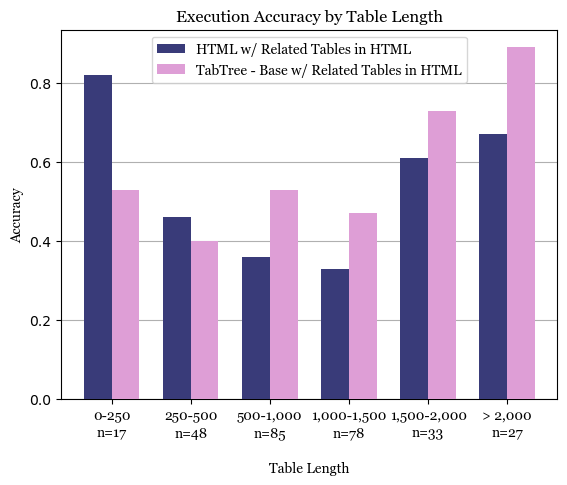

In [53]:
from matplotlib import cm




match_list_html = load_json("../data/evaluation/ir/match_list-2025-03-27-22-48-09.json")


html = [result for result in baselines if result["name"]=="baselines-without-merging-html-RT-html"][0]["qa_results"]
predictions_html = html["data"]["predictions_parsed:"]
ground_truths_html = html["data"]["ground_truths"]

html_accuracies = calculate_official_accuracy(predictions_html, ground_truths_html)[1]

tabtree_base_table_length = [result for result in tabtree_base if result["name"]=="tabtree-without-merging-tabtree-base-RT-html"][0]["qa_results"]
predictions_tabtree_base = tabtree_base_table_length["data"]["predictions_parsed:"]
ground_truths_tabtree_base = tabtree_base_table_length["data"]["ground_truths"]

tabtree_base_accuracies = calculate_official_accuracy(predictions_tabtree_base, ground_truths_tabtree_base)[1]

table_lengths = [num_tokens_from_string(question["question_html_table_parsed"][0]) for question in match_list_html]
table_length_bins = [250, 500, 1000, 1500, 2000, 8000]
table_length_bin_descriptions_start = ["0-250", "250-500", "500-1,000", "1,000-1,500", "1,500-2,000", "> 2,000"]

# produce a dict with a list of match numbers for each bin
table_length_bins_dict_html = {bin: [] for bin in table_length_bins}
table_length_bins_dict_tabtree = {bin: [] for bin in table_length_bins}


print(f"Length of table lengths: {len(table_lengths)}")
print(f"Length of html accuracies: {len(html_accuracies)}")

# only consider answerable questions so only using the data from table_lengths
for i, table_length in enumerate(table_lengths):
    for bin in table_length_bins:
        if table_length <= bin:
            table_length_bins_dict_html[bin].append(html_accuracies[i])
            table_length_bins_dict_tabtree[bin].append(tabtree_base_accuracies[i])
            break

table_length_bins_descriptions = []
for bin_index, bin in enumerate(table_length_bins):
    table_length_bins_descriptions.append(table_length_bin_descriptions_start[bin_index] + f"\nn={len(table_length_bins_dict_html[bin])}\n")

# generate list sorted by category for plotting
category_accuracy_dict_html = [calculate_accuracy_by_binary_list(table_length_bins_dict_html[bin]) for bin in table_length_bins]
category_accuracy_dict_tabtree = [calculate_accuracy_by_binary_list(table_length_bins_dict_tabtree[bin]) for bin in table_length_bins]

print(f"HTML Accuracies: {category_accuracy_dict_html}")
print(f"TabTree Accuracies: {category_accuracy_dict_tabtree}")


categories = table_length_bins_descriptions
wrapped_labels = table_length_bins_descriptions

# Define colors for each category
colors = cm.get_cmap('tab20b', 2)

fig, ax = plt.subplots()
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, category_accuracy_dict_html, width, label='HTML w/ Related Tables in HTML', color=colors(0), zorder=3)
rects2 = ax.bar(x + width/2, category_accuracy_dict_tabtree, width, label='TabTree - Base w/ Related Tables in HTML' , color=colors(1), zorder=3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy', fontname='Georgia')
ax.set_xlabel('Table Length', fontname='Georgia')
ax.set_title('Execution Accuracy by Table Length', fontname='Georgia')
ax.set_xticks(x)

ax.set_xticklabels(wrapped_labels, fontname='Georgia')
ax.legend(prop={'family': 'Georgia'})

ax.yaxis.grid(True, zorder=0)
ax.set_axisbelow(True)  # Move grid to background

plt.show()

# save plot to pdf
fig.savefig("../data/results/full_qa_accuracy_by_table_length.pdf", bbox_inches='tight')


### Question Category Analysis

HTML Accuracies: [0.43, 0.42, 0.48, 0.48, 0.72]
TabTree Accuracies: [0.47, 0.55, 0.57, 0.59, 0.89]


/var/folders/7d/g2j4hccn7pxdk3cp75110hcr0000gn/T/ipykernel_2731/580424449.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20b', 2)


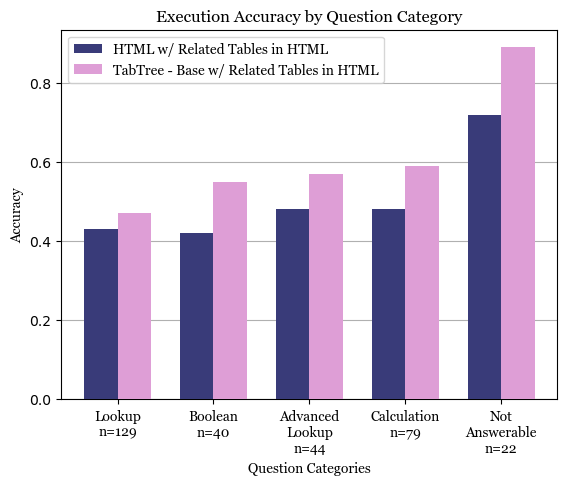

In [55]:
# create list for each category
import textwrap


match_list_html = load_json("../data/sec_filings/0_id_mapper_questions.json")

category_match_dict_html = {}
category_match_dict_tabtree = {}

# pad match list with non answerable questions to length of html_accuracies
category_list = [question["category"] for question in match_list_html]
for category, accuracy in zip(category_list, html_accuracies):
    if category not in category_match_dict_html:
        category_match_dict_html[category] = []
    category_match_dict_html[category].append(accuracy)

for category, accuracy in zip(category_list, tabtree_base_accuracies):
    if category not in category_match_dict_tabtree:
        category_match_dict_tabtree[category] = []
    category_match_dict_tabtree[category].append(accuracy)
    
# calculate accuracy for each category -- html:
category_accuracy_dict_html = {}
for category, matches in category_match_dict_html.items():
    accuracy = calculate_accuracy_by_binary_list(matches)
    category_accuracy_dict_html[category] = accuracy
    
# calculate accuracy for each category -- tabtree:
category_accuracy_dict_tabtree = {}
for category, matches in category_match_dict_tabtree.items():
    accuracy = calculate_accuracy_by_binary_list(matches)
    category_accuracy_dict_tabtree[category] = accuracy


# plot accuracy for each category as grouped bar chart for phi-4 vs html
categories = ["lookup", "boolean", "advanced lookup", "calculation", "not answerable"]

# generate list sorted by category for plotting
category_accuracy_dict_html = [category_accuracy_dict_html[category] for category in categories]
category_accuracy_dict_tabtree = [category_accuracy_dict_tabtree[category] for category in categories]


print(f"HTML Accuracies: {category_accuracy_dict_html}")
print(f"TabTree Accuracies: {category_accuracy_dict_tabtree}")

# count the number of questions in each category
category_counts = {}
for question in match_list_html:
    if question["category"] not in category_counts:
        category_counts[question["category"]] = 0
    category_counts[question["category"]] += 1


# Wrap labels if they are too long
wrapped_labels = []
for label in categories:
    wrapped_label = textwrap.fill(" ".join(word.capitalize() for word in label.split()), 11)
    wrapped_label += f"\nn={category_counts[label]}"
    wrapped_labels.append(wrapped_label)



# Define colors for each category
colors = cm.get_cmap('tab20b', 2)

fig, ax = plt.subplots()
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, category_accuracy_dict_html, width, label='HTML w/ Related Tables in HTML', color=colors(0), zorder=3)
rects2 = ax.bar(x + width/2, category_accuracy_dict_tabtree, width, label='TabTree - Base w/ Related Tables in HTML' , color=colors(1), zorder=3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy', fontname='Georgia')
ax.set_xlabel('Question Categories', fontname='Georgia')
ax.set_title('Execution Accuracy by Question Category', fontname='Georgia')
ax.set_xticks(x)
ax.set_xticklabels(wrapped_labels, fontname='Georgia')
ax.legend(prop={'family': 'Georgia'})


ax.yaxis.grid(True, zorder=0)
ax.set_axisbelow(True)  # Move grid to background

plt.show()

# save plot to pdf
fig.savefig("../data/results/full_qa_accuracy_by_category.pdf", bbox_inches='tight')


    
    